# 1. Load Libraries  

In [63]:

# Core Python Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Plotting
from plotnine import (  # python很常只import你要的function，不會import整個package
    ggplot, aes, geom_col,
    geom_col, geom_line, geom_smooth,
    facet_wrap,
    scale_y_continuous,
    scale_x_datetime,
    labs,
    expand_limits,
    theme, theme_minimal, theme_matplotlib
)
from mizani.breaks import date_breaks
from mizani.formatters import date_format, currency_format

# Misc
from os import mkdir, getcwd  # mkder是os的一個function(意思是，我不能再用mkdir.xxx)
# pretty 是 rich 下的一個 module。他叫module不叫function，因為他還可以用 pretty.xxx
from rich import pretty
pretty.install()  # 這只會影響目前 python console 的結果，他沒有真的安裝什麼東西
# rich這個package是用來做terminal formatting用的，讓terminal變漂亮一點
# 例如我現在重新執行 numpy 的計算，會發現結果的顏色變藍色，比較能區分 code 和 result 了
np.sum([1, 2, 3])

6

# 2. Importing Data Files

In [2]:
bikes_df = pd.read_excel("./00_data_raw/bikes.xlsx", engine='openpyxl')
bikeshops_df = pd.read_excel("./00_data_raw/bikeshops.xlsx", engine='openpyxl')
orderlines_df = pd.read_excel(
    io = "./00_data_raw/orderlines2.xlsx",
    engine='openpyxl',
    converters={'order.date': str}
)

# 3. Examining Data

## 3.1 看一下三張資料表

* 首先來看看 `bikes_df` 這個資料集

In [3]:
bikes_df.head(5)

,bike.id,model,description,price
0,1,Supersix Evo Black Inc.,Road - Elite Road - Carbon,12790
1,2,Supersix Evo Hi-Mod Team,Road - Elite Road - Carbon,10660
2,3,Supersix Evo Hi-Mod Dura Ace 1,Road - Elite Road - Carbon,7990
3,4,Supersix Evo Hi-Mod Dura Ace 2,Road - Elite Road - Carbon,5330
4,5,Supersix Evo Hi-Mod Utegra,Road - Elite Road - Carbon,4260


* 可以看到，每一個 row 就是一台腳踏車，後續的欄位就是描述這台腳踏車的 機型(model), 介紹(description), 和價錢(price)

* 再來看看 `bikeshops_df` 這個資料集

In [4]:
bikeshops_df.head(5)

,bikeshop.id,bikeshop.name,location
0,1,Pittsburgh Mountain Machines,"Pittsburgh, PA"
1,2,Ithaca Mountain Climbers,"Ithaca, NY"
2,3,Columbus Race Equipment,"Columbus, OH"
3,4,Detroit Cycles,"Detroit, MI"
4,5,Cincinnati Speed,"Cincinnati, OH"


* 可以看到，每一個 row 是一個腳踏車店，裡面有他的 id, 店名, 和 地址(location)

* 最後，來看看 `orderlines_df`

In [5]:
orderlines_df.head(10)

,order.id,order.line,order.date,customer.id,product.id,quantity
0,1,1,2011-01-07 00:00:00,2,48,1
1,1,2,2011-01-07 00:00:00,2,52,1
2,2,1,2011-01-10 00:00:00,10,76,1
3,2,2,2011-01-10 00:00:00,10,52,1
4,3,1,2011-01-10 00:00:00,6,2,1
5,3,2,2011-01-10 00:00:00,6,50,1
6,3,3,2011-01-10 00:00:00,6,1,1
7,3,4,2011-01-10 00:00:00,6,4,1
8,3,5,2011-01-10 00:00:00,6,34,1
9,4,1,2011-01-11 00:00:00,22,26,1


* 這是在講腳踏車的下單狀況。
* 倒數第二個column的 `product.id`對應到 `bikes_df` 這個資料表的 `bike.id`，所以是在講某一台腳踏車。  
* 倒數第三個column的 `customer.id` 對應到 `bikeshops_df` 這個資料表的 `bikeshop.id`，所以是在哪一家腳踏車店做的訂購  
* 所以合起來看，就是在某個時間(order.date)，我們賣給某家腳踏車行(customer.id)某個腳踏車(product.id)共多少台車(quantity)的資料

## 3.2 Exploration

### 3.2.1 最常出現的 5 種 description

* 剛剛在 `bikes_df` 資料表中，每一台腳踏車，都有他的 description
* 但我們也發現，不同腳踏車，常常會 share 同一個 description (例如前五台腳踏車，description都是 `Road - Elite Road - Carbon`) 
* 所以，對我來說，description 可能就是在幫腳踏車分群，告訴我們這是哪一種類型的腳踏車這樣  
* 那我現在想來看看，最常出現的 5 種 description 是哪些 
* 在 pandas 中會這樣做：

In [6]:
# 先取出那一個 column (在 pandas 中，這時的資料格式叫 series，不是 data.frame)
s = bikes_df["description"]
print(s)

0      Road - Elite Road - Carbon
1      Road - Elite Road - Carbon
2      Road - Elite Road - Carbon
3      Road - Elite Road - Carbon
4      Road - Elite Road - Carbon
                 ...             
92    Mountain - Sport - Aluminum
93    Mountain - Sport - Aluminum
94    Mountain - Sport - Aluminum
95    Mountain - Sport - Aluminum
96    Mountain - Sport - Aluminum
Name: description, Length: 97, dtype: object


In [7]:
# 再對這個 object 做 `.value_counts()` 這個 method，可以得到次數分配表
freq_count_series = s.value_counts()
print(freq_count_series)

Mountain - Cross Country Race - Carbon      14
Road - Endurance Road - Carbon              11
Road - Elite Road - Aluminum                11
Road - Elite Road - Carbon                  10
Mountain - Sport - Aluminum                  9
Mountain - Trail - Aluminum                  8
Mountain - Over Mountain - Carbon            8
Road - Endurance Road - Aluminum             5
Mountain - Cross Country Race - Aluminum     5
Mountain - Trail - Carbon                    5
Road - Triathalon - Carbon                   5
Road - Cyclocross - Carbon                   4
Mountain - Fat Bike - Aluminum               2
Name: description, dtype: int64


In [8]:
# 最後用 `.nlargest(5)`，篩選出前五名
print(freq_count_series.nlargest(5))

Mountain - Cross Country Race - Carbon    14
Road - Endurance Road - Carbon            11
Road - Elite Road - Aluminum              11
Road - Elite Road - Carbon                10
Mountain - Sport - Aluminum                9
Name: description, dtype: int64


In [9]:
# 那整個過程，可以用 `method chaining`把他串起來，也就是用一堆 "." 串起來
top5_bikes_series = bikes_df['description'].value_counts().nlargest(5)
print(top5_bikes_series)

Mountain - Cross Country Race - Carbon    14
Road - Endurance Road - Carbon            11
Road - Elite Road - Aluminum              11
Road - Elite Road - Carbon                10
Mountain - Sport - Aluminum                9
Name: description, dtype: int64


In [10]:
# 也可以用 "\" 加 enter 換行，製造出 pipeline 的效果
top5_bikes_series = bikes_df['description'] \
    .value_counts() \
        .nlargest(5)
print(top5_bikes_series)

Mountain - Cross Country Race - Carbon    14
Road - Endurance Road - Carbon            11
Road - Elite Road - Aluminum              11
Road - Elite Road - Carbon                10
Mountain - Sport - Aluminum                9
Name: description, dtype: int64


### 3.2.2 畫出最常出現的 5 個 description

* 先查一下畫圖怎麼畫： `?pd.Series.plot()`  

In [11]:
?pd.Series.plot

Init signature: pd.Series.plot(data)
Docstring:     
Make plots of Series or DataFrame.

Uses the backend specified by the
option ``plotting.backend``. By default, matplotlib is used.

Parameters
----------
data : Series or DataFrame
    The object for which the method is called.
x : label or position, default None
    Only used if data is a DataFrame.
y : label, position or list of label, positions, default None
    Allows plotting of one column versus another. Only used if data is a
    DataFrame.
kind : str
    The kind of plot to produce:

    - 'line' : line plot (default)
    - 'bar' : vertical bar plot
    - 'barh' : horizontal bar plot
    - 'hist' : histogram
    - 'box' : boxplot
    - 'kde' : Kernel Density Estimation plot
    - 'density' : same as 'kde'
    - 'area' : area plot
    - 'pie' : pie plot
    - 'scatter' : scatter plot
    - 'hexbin' : hexbin plot.
ax : matplotlib axes object, default None
    An axes of the current figure.
subplots : bool, default False
    Mak

<AxesSubplot:>

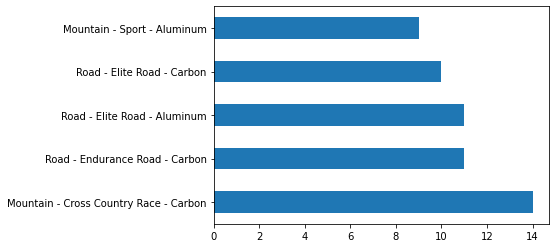

In [12]:
fig = top5_bikes_series.plot(kind="barh")
fig

# 4. Joing the excel tables

* 剛剛已經知道，`orderlines_df` 這個資料集裡面的 `product.id` 對應到 `bikes_df` 資料集的 `product.id`
* 也知道 `orderlines_df` 這個資料集裡面的 `customer.id` 對應到 `bikeshops_df` 資料集裡面的 `bikeshop.id`  
* 那我們現在就以 `orderlines_df` 為底，然後把兩份資料 join 過來

In [13]:
bike_orderlines_joined_df = orderlines_df \
    .merge(
        right = bikes_df,
        how = 'left', # left_join 的意思
        left_on = 'product.id',
        right_on = 'bike.id'
    ) \
    .merge(
        right = bikeshops_df,
        how = 'left',
        left_on = 'customer.id',
        right_on = 'bikeshop.id'
    )
bike_orderlines_joined_df.head(10)

,order.id,order.line,order.date,customer.id,product.id,quantity,bike.id,model,description,price,bikeshop.id,bikeshop.name,location
0,1,1,2011-01-07 00:00:00,2,48,1,48,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,2,Ithaca Mountain Climbers,"Ithaca, NY"
1,1,2,2011-01-07 00:00:00,2,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,2,Ithaca Mountain Climbers,"Ithaca, NY"
2,2,1,2011-01-10 00:00:00,10,76,1,76,Beast of the East 1,Mountain - Trail - Aluminum,2770,10,Kansas City 29ers,"Kansas City, KS"
3,2,2,2011-01-10 00:00:00,10,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,10,Kansas City 29ers,"Kansas City, KS"
4,3,1,2011-01-10 00:00:00,6,2,1,2,Supersix Evo Hi-Mod Team,Road - Elite Road - Carbon,10660,6,Louisville Race Equipment,"Louisville, KY"
5,3,2,2011-01-10 00:00:00,6,50,1,50,Jekyll Carbon 4,Mountain - Over Mountain - Carbon,3200,6,Louisville Race Equipment,"Louisville, KY"
6,3,3,2011-01-10 00:00:00,6,1,1,1,Supersix Evo Black Inc.,Road - Elite Road - Carbon,12790,6,Louisville Race Equipment,"Louisville, KY"
7,3,4,2011-01-10 00:00:00,6,4,1,4,Supersix Evo Hi-Mod Dura Ace 2,Road - Elite Road - Carbon,5330,6,Louisville Race Equipment,"Louisville, KY"
8,3,5,2011-01-10 00:00:00,6,34,1,34,Synapse Disc 105,Road - Endurance Road - Aluminum,1570,6,Louisville Race Equipment,"Louisville, KY"
9,4,1,2011-01-11 00:00:00,22,26,1,26,Synapse Carbon Disc Ultegra D12,Road - Endurance Road - Carbon,4800,22,Ann Arbor Speed,"Ann Arbor, MI"


# 5. Wrangling Data

* 首先，我們來提醒一下 `.copy` 的用法

In [14]:
df = bike_orderlines_joined_df # 如果 df 變了， bike_orderlines_joined_df 會跟著變，因為他們 reference 到同一個記憶體位置
df2 = bike_orderlines_joined_df.copy() # 如果 df2 變了，bike_orderlines_joined_df 不會跟著變，因為你用 copy 時，他會開一個新的記憶體位置給 df2

## 5.1 Handle Dates

* 原本的資料， order.date 這個欄位的類型是 `object` (在這邊理解成 string 就好)，不是我期望的 datetime

In [15]:
print(bike_orderlines_joined_df['order.date'])

0        2011-01-07 00:00:00
1        2011-01-07 00:00:00
2        2011-01-10 00:00:00
3        2011-01-10 00:00:00
4        2011-01-10 00:00:00
                ...         
15639    2015-12-25 00:00:00
15640    2015-12-25 00:00:00
15641    2015-12-25 00:00:00
15642    2015-12-25 00:00:00
15643    2015-12-25 00:00:00
Name: order.date, Length: 15644, dtype: object


* 所以，我要對這欄作轉換

In [16]:
df2['order.date'] = pd.to_datetime(df2['order.date'])
print(df2['order.date'])

0       2011-01-07
1       2011-01-07
2       2011-01-10
3       2011-01-10
4       2011-01-10
           ...    
15639   2015-12-25
15640   2015-12-25
15641   2015-12-25
15642   2015-12-25
15643   2015-12-25
Name: order.date, Length: 15644, dtype: datetime64[ns]


* 轉換後，就變成 `datetime64` 的格式了
* 那 datetime 格式的好處是，他就有對應的 method, attribute 可以用，例如，我可以擷取年份資訊：

In [17]:
order_date_series = df2['order.date']
print(order_date_series.dt.year)

0        2011
1        2011
2        2011
3        2011
4        2011
         ... 
15639    2015
15640    2015
15641    2015
15642    2015
15643    2015
Name: order.date, Length: 15644, dtype: int64


## 5.2 Splitting text data

* 我們原本的資料， `description` 這個欄位，會用 `-` 來間隔三個字串：

In [18]:
print(df2.description)

0               Mountain - Over Mountain - Carbon
1               Mountain - Over Mountain - Carbon
2                     Mountain - Trail - Aluminum
3               Mountain - Over Mountain - Carbon
4                      Road - Elite Road - Carbon
                           ...                   
15639                Road - Elite Road - Aluminum
15640                 Mountain - Sport - Aluminum
15641                Road - Elite Road - Aluminum
15642      Mountain - Cross Country Race - Carbon
15643    Mountain - Cross Country Race - Aluminum
Name: description, Length: 15644, dtype: object


* 那我現在想把這個字串，拆解成三個欄位，並分別命名成 category_1, category_2, and frame_material

* 這邊先介紹一個字串的method: `split()`，例如這樣用：

In [19]:
"Moutain - Over Mountain - Carbon".split(" - ")

['Moutain', 'Over Mountain', 'Carbon']

* 那要用在 pandas 的 dataframe 格式時，就發現如果加個 `.str`，後面就有 string 的那些 method 可以用，所以我可以寫成這樣：

In [20]:
print(df2['description'].str.split(" - "))

0               [Mountain, Over Mountain, Carbon]
1               [Mountain, Over Mountain, Carbon]
2                     [Mountain, Trail, Aluminum]
3               [Mountain, Over Mountain, Carbon]
4                      [Road, Elite Road, Carbon]
                           ...                   
15639                [Road, Elite Road, Aluminum]
15640                 [Mountain, Sport, Aluminum]
15641                [Road, Elite Road, Aluminum]
15642      [Mountain, Cross Country Race, Carbon]
15643    [Mountain, Cross Country Race, Aluminum]
Name: description, Length: 15644, dtype: object


* 還不賴，但不是我要的，因為我要切成三個 column。 那 `split()` 裡面還有個參數叫 `expand = True`，就可以把欄位拆開：

In [21]:
temp_df = df2['description'].str.split(pat = " - ", expand = True)
print(temp_df)

              0                   1         2
0      Mountain       Over Mountain    Carbon
1      Mountain       Over Mountain    Carbon
2      Mountain               Trail  Aluminum
3      Mountain       Over Mountain    Carbon
4          Road          Elite Road    Carbon
...         ...                 ...       ...
15639      Road          Elite Road  Aluminum
15640  Mountain               Sport  Aluminum
15641      Road          Elite Road  Aluminum
15642  Mountain  Cross Country Race    Carbon
15643  Mountain  Cross Country Race  Aluminum

[15644 rows x 3 columns]


* nice，拆開來了，但欄位名稱不是我要的，而且，也還沒塞回原本的資料集
* 那課程中的做法，我覺得超爛，但現在我也不知道 dplyr 的那種作法在 python 怎麼做，所以只好先用課程中的做法來處理，如下：

In [22]:
df2['category.1'] = temp_df[0]
df2['category.2'] = temp_df[1]
df2['frame.material'] = temp_df[2]
df2.head(5)

,order.id,order.line,order.date,customer.id,product.id,quantity,bike.id,model,description,price,bikeshop.id,bikeshop.name,location,category.1,category.2,frame.material
0,1,1,2011-01-07,2,48,1,48,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,2,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon
1,1,2,2011-01-07,2,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,2,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon
2,2,1,2011-01-10,10,76,1,76,Beast of the East 1,Mountain - Trail - Aluminum,2770,10,Kansas City 29ers,"Kansas City, KS",Mountain,Trail,Aluminum
3,2,2,2011-01-10,10,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,10,Kansas City 29ers,"Kansas City, KS",Mountain,Over Mountain,Carbon
4,3,1,2011-01-10,6,2,1,2,Supersix Evo Hi-Mod Team,Road - Elite Road - Carbon,10660,6,Louisville Race Equipment,"Louisville, KY",Road,Elite Road,Carbon


* 打鐵趁熱， `location` 的內容長這樣： "Austin, TX"，所以，我想把 location 拆解成 city 和 state 兩個欄位  
* 作法一樣： 

In [23]:
temp_df = df2['location'].str.split(', ', expand = True)
temp_df

,0,1
0,Ithaca,NY
1,Ithaca,NY
2,Kansas City,KS
3,Kansas City,KS
4,Louisville,KY
...,...,...
15639,Austin,TX
15640,Austin,TX
15641,Austin,TX
15642,Austin,TX


In [24]:
df2['city'] = temp_df[0]
df2['state'] = temp_df[1]
df2

,order.id,order.line,order.date,customer.id,product.id,quantity,bike.id,model,description,price,bikeshop.id,bikeshop.name,location,category.1,category.2,frame.material,city,state
0,1,1,2011-01-07,2,48,1,48,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,2,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,Ithaca,NY
1,1,2,2011-01-07,2,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,2,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,Ithaca,NY
2,2,1,2011-01-10,10,76,1,76,Beast of the East 1,Mountain - Trail - Aluminum,2770,10,Kansas City 29ers,"Kansas City, KS",Mountain,Trail,Aluminum,Kansas City,KS
3,2,2,2011-01-10,10,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,10,Kansas City 29ers,"Kansas City, KS",Mountain,Over Mountain,Carbon,Kansas City,KS
4,3,1,2011-01-10,6,2,1,2,Supersix Evo Hi-Mod Team,Road - Elite Road - Carbon,10660,6,Louisville Race Equipment,"Louisville, KY",Road,Elite Road,Carbon,Louisville,KY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15639,2000,4,2015-12-25,15,14,1,14,CAAD Disc Ultegra,Road - Elite Road - Aluminum,2660,15,Austin Cruisers,"Austin, TX",Road,Elite Road,Aluminum,Austin,TX
15640,2000,5,2015-12-25,15,90,1,90,Trail 2,Mountain - Sport - Aluminum,1350,15,Austin Cruisers,"Austin, TX",Mountain,Sport,Aluminum,Austin,TX
15641,2000,6,2015-12-25,15,17,1,17,CAAD12 105,Road - Elite Road - Aluminum,1680,15,Austin Cruisers,"Austin, TX",Road,Elite Road,Aluminum,Austin,TX
15642,2000,7,2015-12-25,15,70,1,70,F-Si Carbon 4,Mountain - Cross Country Race - Carbon,2880,15,Austin Cruisers,"Austin, TX",Mountain,Cross Country Race,Carbon,Austin,TX


## 5.3 mutate出新 column: total.price

* 原始資料中，有 `quantity`, 也有 `price` ，所以我想計算出 total.price

In [25]:
df2['total.price'] = df2['quantity']*df2['price']
df2.head(5)

,order.id,order.line,order.date,customer.id,product.id,quantity,bike.id,model,description,price,bikeshop.id,bikeshop.name,location,category.1,category.2,frame.material,city,state,total.price
0,1,1,2011-01-07,2,48,1,48,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,2,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,Ithaca,NY,6070
1,1,2,2011-01-07,2,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,2,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,Ithaca,NY,5970
2,2,1,2011-01-10,10,76,1,76,Beast of the East 1,Mountain - Trail - Aluminum,2770,10,Kansas City 29ers,"Kansas City, KS",Mountain,Trail,Aluminum,Kansas City,KS,2770
3,2,2,2011-01-10,10,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,10,Kansas City 29ers,"Kansas City, KS",Mountain,Over Mountain,Carbon,Kansas City,KS,5970
4,3,1,2011-01-10,6,2,1,2,Supersix Evo Hi-Mod Team,Road - Elite Road - Carbon,10660,6,Louisville Race Equipment,"Louisville, KY",Road,Elite Road,Carbon,Louisville,KY,10660


## 5.4 重新排列欄位順序

* 在 R 裡面，是用 `select(data, var1, var3, var2,...)` 來排順序  
* 在 pandas 中，就是用 `data[['var1', 'var3', 'var2']]` 來排順序  
* 所以，作法蠻暴力的：  
  * 先用 `data.columns` ，在 console 中 print 出所有欄位名稱  
  * 剪下貼上到 script 上，自己排順序，排完後存成一個 list  
  * 最後用 `data[排好的list物件]` 來完成  
* 做做看吧：  

In [26]:
df2.columns

Index(['order.id', 'order.line', 'order.date', 'customer.id', 'product.id',
       'quantity', 'bike.id', 'model', 'description', 'price', 'bikeshop.id',
       'bikeshop.name', 'location', 'category.1', 'category.2',
       'frame.material', 'city', 'state', 'total.price'],
      dtype='object')

In [27]:
cols_to_keep_list = [
    'order.id', 
    'order.line', 
    'order.date', 
    # 'customer.id', 
    # 'product.id',
    # 'quantity', 
    # 'bike.id', 
    'model', 
    # 'description', 
    'price', 
    'total.price',
    # 'bikeshop.id',
    'bikeshop.name', 
    'location', 
    'category.1', 
    'category.2',
    'frame.material', 
    'city', 
    'state'
]
df2[cols_to_keep_list].head(5)

,order.id,order.line,order.date,model,price,total.price,bikeshop.name,location,category.1,category.2,frame.material,city,state
0,1,1,2011-01-07,Jekyll Carbon 2,6070,6070,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,Ithaca,NY
1,1,2,2011-01-07,Trigger Carbon 2,5970,5970,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,Ithaca,NY
2,2,1,2011-01-10,Beast of the East 1,2770,2770,Kansas City 29ers,"Kansas City, KS",Mountain,Trail,Aluminum,Kansas City,KS
3,2,2,2011-01-10,Trigger Carbon 2,5970,5970,Kansas City 29ers,"Kansas City, KS",Mountain,Over Mountain,Carbon,Kansas City,KS
4,3,1,2011-01-10,Supersix Evo Hi-Mod Team,10660,10660,Louisville Race Equipment,"Louisville, KY",Road,Elite Road,Carbon,Louisville,KY


## 5.5 Renaming columns

* 我們其實很不喜歡 column name 中有 '.'，例如 `order.date`  
* 因為這樣在物件導向中，會以為你要用 attribute/method  
* 所以，我想把所有的 '.' 都換成 '_'  
* 在字串中，我們可以用 `.replace()` 來處理，例如：

In [28]:
"order.id".replace(".","_")

'order_id'

* 那要用在 pandas dataframe 上，就一樣，先給他 `.str` ，表示進入到 string 的 attribute 中，接著再用 `.replace()` 就好

In [29]:
print(df2.columns) # 原本的名稱
print(df2.columns.str.replace(".","_")) # 轉換後名稱

Index(['order.id', 'order.line', 'order.date', 'customer.id', 'product.id',
       'quantity', 'bike.id', 'model', 'description', 'price', 'bikeshop.id',
       'bikeshop.name', 'location', 'category.1', 'category.2',
       'frame.material', 'city', 'state', 'total.price'],
      dtype='object')
Index(['order_id', 'order_line', 'order_date', 'customer_id', 'product_id',
       'quantity', 'bike_id', 'model', 'description', 'price', 'bikeshop_id',
       'bikeshop_name', 'location', 'category_1', 'category_2',
       'frame_material', 'city', 'state', 'total_price'],
      dtype='object')


* 最後，就把這個名稱塞回去原本的 df 就好：

In [30]:
df2

,order.id,order.line,order.date,customer.id,product.id,quantity,bike.id,model,description,price,bikeshop.id,bikeshop.name,location,category.1,category.2,frame.material,city,state,total.price
0,1,1,2011-01-07,2,48,1,48,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,2,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,Ithaca,NY,6070
1,1,2,2011-01-07,2,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,2,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,Ithaca,NY,5970
2,2,1,2011-01-10,10,76,1,76,Beast of the East 1,Mountain - Trail - Aluminum,2770,10,Kansas City 29ers,"Kansas City, KS",Mountain,Trail,Aluminum,Kansas City,KS,2770
3,2,2,2011-01-10,10,52,1,52,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,10,Kansas City 29ers,"Kansas City, KS",Mountain,Over Mountain,Carbon,Kansas City,KS,5970
4,3,1,2011-01-10,6,2,1,2,Supersix Evo Hi-Mod Team,Road - Elite Road - Carbon,10660,6,Louisville Race Equipment,"Louisville, KY",Road,Elite Road,Carbon,Louisville,KY,10660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15639,2000,4,2015-12-25,15,14,1,14,CAAD Disc Ultegra,Road - Elite Road - Aluminum,2660,15,Austin Cruisers,"Austin, TX",Road,Elite Road,Aluminum,Austin,TX,2660
15640,2000,5,2015-12-25,15,90,1,90,Trail 2,Mountain - Sport - Aluminum,1350,15,Austin Cruisers,"Austin, TX",Mountain,Sport,Aluminum,Austin,TX,1350
15641,2000,6,2015-12-25,15,17,1,17,CAAD12 105,Road - Elite Road - Aluminum,1680,15,Austin Cruisers,"Austin, TX",Road,Elite Road,Aluminum,Austin,TX,1680
15642,2000,7,2015-12-25,15,70,1,70,F-Si Carbon 4,Mountain - Cross Country Race - Carbon,2880,15,Austin Cruisers,"Austin, TX",Mountain,Cross Country Race,Carbon,Austin,TX,2880


In [31]:
df2.columns = df2.columns.str.replace(".","_")
print(df2.columns)

Index(['order_id', 'order_line', 'order_date', 'customer_id', 'product_id',
       'quantity', 'bike_id', 'model', 'description', 'price', 'bikeshop_id',
       'bikeshop_name', 'location', 'category_1', 'category_2',
       'frame_material', 'city', 'state', 'total_price'],
      dtype='object')


# 6. Save your work: pickle it!!

* 剛剛辛苦的整理完資料了，那習慣上就會把這筆資料存起來，之後就可以直接從乾淨的資料開始分析和畫圖  

In [32]:
bike_orderlines_wrangle_df = df2
# bike_orderlines_wrangle_df.save_pickle("00_data_wrangled/bike_orderlines_wrangled_df.pkl")

# 7. Sales Analysis 

In [33]:
df = pd.read_pickle("00_data_wrangled/bike_orderlines_wrangled_df.pkl")

## 7.1 各月銷售金額統計

* 接下來，我們想抓出 `order_date` 和 `total_price` 這兩個變數，然後畫畫圖  
* 那首先，我們把 `order_date` 從變數欄 移到 index 欄(就是 rownames 的意思)，那這樣做的用意是，等等才能用一些datetime可用的method
* 接著，用 `.resample(rule = "Y")` 來表示我要先將資料變成"年"的顆粒度，然後再 by 年 做 group_by，做出 group_by object。這邊多說明一下，轉成年後，預設是會以該年的最後一天為代表。例如2021年，他會寫成 2021-12-31。所以如果你喜歡用年初當代表(e.g. 2021-01-01)，那就要寫成 `.resample(rule = "YS")` ，那 YS 就是 Year Start 的縮寫。最後，如果你想 by 月，那要用 `rule = "M"`  
* 最後，就是用 `.sum()` 的函數，算出各年的總賣出金額：

In [52]:
sales_by_month_df = df[['order_date','total_price']] \
    .set_index('order_date') \
    .resample(rule = "MS") \
    .sum() \
    .reset_index()
sales_by_month_df.head()

,order_date,total_price
0,2011-01-01,483015
1,2011-02-01,1162075
2,2011-03-01,659975
3,2011-04-01,1827140
4,2011-05-01,844170


## 7.2 畫圖

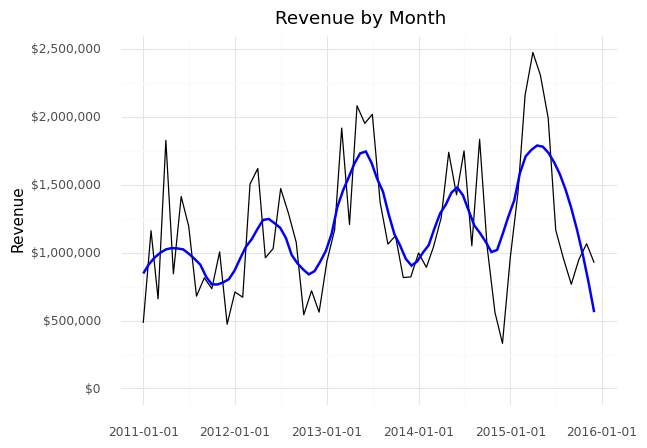

<ggplot: (314637222)>

In [64]:
ggplot(aes(x = "order_date", y = "total_price"), data = sales_by_month_df) + \
    geom_line() + \
    geom_smooth(
        method = 'loess',
        se = False,
        color = "blue",
        span = 0.3
    ) + \
    scale_y_continuous(labels = currency_format(prefix = "$", digits = 0, big_mark = ",")) + \
    labs(
        title = "Revenue by Month",
        x = "",
        y = "Revenue"
    ) + \
    theme_minimal() + \
    expand_limits(y = 0)


In [55]:
!pip install scikit-misc

     |████████████████████████████████| 10.9 MB 1.7 MB/s 
You should consider upgrading via the '/Users/hanklee/.pyenv/versions/3.8.0/bin/python3.8 -m pip install --upgrade pip' command.
